# Modelo Keras secuencial


*   5 capas ocultas densas de 200, 500, 500, 1000, 1000 unidades
*   Activación 'Relu'
*   Loss MSE
*   Métrica MAE
*   Adam Learning Rate 1e-6
*   2000 epochs



In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LeakyReLU
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split
from datetime import datetime

PATH = r'/content/drive/My Drive/Colab Notebooks/'
PATH_MODELS= r'/content/drive/My Drive/Colab Notebooks/models/'
DATA_INPUT_FILE= r'data_h2o_HF_ccpvdz.csv'
OUTPUT_FILES = r'seq_3cv11'

# Carga de datos
17636 registros

In [3]:
data= pd.read_csv(PATH + DATA_INPUT_FILE, index_col= 0)
data.describe()

,rh1,rh2,ang,energia
count,17636.000000,17636.000000,17636.000000,17636.000000
mean,1.718462,1.718462,104.482706,-75.741635
std,0.465277,0.465277,4.329904,0.428579
min,0.800000,0.800000,94.500000,-76.027388
25%,1.400000,1.400000,102.500000,-75.992674
50%,1.708000,1.708000,104.500000,-75.924886
75%,2.025000,2.025000,106.500000,-75.722473
max,2.800000,2.800000,114.500000,-72.066162


# Transformación de las variables para el entrenamiento
*   x_input: Se normalizan las variables predictoras
*   y_input: Se le resta el mínimo a la variable objetivo


In [4]:
#Se normalizan las variables predictoras
x = data[['ang', 'rh1', 'rh2']].copy()
x_describe= x.describe()
x_stats = x_describe.transpose()
x_input = (x - x_stats['mean']) / x_stats['std']

# Se le resta el mínimo a la variable objetivo
minimo=min(data['energia'])
y_input = data['energia'].copy() -minimo


# Creación de los conjuntos de train y validacción
Conjunto de validación del 10%

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(x_input, y_input , random_state = 33, test_size = 0.1)

# Definición de la arquitectura

In [6]:
#Modelo
model = keras.Sequential([
    layers.Dense(200, activation='relu', input_shape=[len(x_train.keys())]),
    layers.Dense(500, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1)
  ])

#Optimizador 
optimizer = keras.optimizers.Adam(learning_rate=1e-6)

model.compile( loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mean_squared_logarithmic_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 500)               100500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              501000    
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1001      
Total params: 1,854,801
Trainable params: 1,854,801
Non-trainable params: 0
______________________________________________

# Callback

In [7]:
#Se guarda el mejor modelo según la métrica de referencia MAE
callback_mejor_modelo = tf.keras.callbacks.ModelCheckpoint(
    filepath= PATH_MODELS + OUTPUT_FILES + r'_best.h5',
    monitor='val_mae',
    mode='min',
    save_best_only=True)

# Entrenamiento

In [8]:
EPOCHS = 2000

datetime_comienzo = datetime.now()

#Entrenamiento
history = model.fit(
  x_train, y_train, verbose=0, 
  epochs=EPOCHS, validation_data=(x_valid, y_valid)
  ,callbacks=[callback_mejor_modelo])

datetime_fin = datetime.now()

#Se guarda el modelo
model.save(PATH_MODELS + OUTPUT_FILES + r'.h5',include_optimizer=True, save_format='h5')

print("Tiempo de entrenamiento:" + str(datetime_fin-datetime_comienzo) )

#Historia de entrenamiento a dataframe
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv(PATH_MODELS + 'hist' + OUTPUT_FILES + r'.h5',index=True)
hist.tail(5) 

Tiempo de entrenamiento:0:30:58.835481


,loss,mae,mean_squared_logarithmic_error,val_loss,val_mae,val_mean_squared_logarithmic_error,epoch
1995,0.000184,0.002465,0.000027,0.000023,0.002112,0.000007,1995
1996,0.000179,0.002195,0.000027,0.000023,0.002089,0.000007,1996
1997,0.000178,0.002309,0.000027,0.000024,0.001956,0.000007,1997
1998,0.000193,0.002517,0.000028,0.000022,0.001960,0.000007,1998
1999,0.000175,0.002223,0.000026,0.000024,0.002093,0.000007,1999


# Representación entrenamiento 

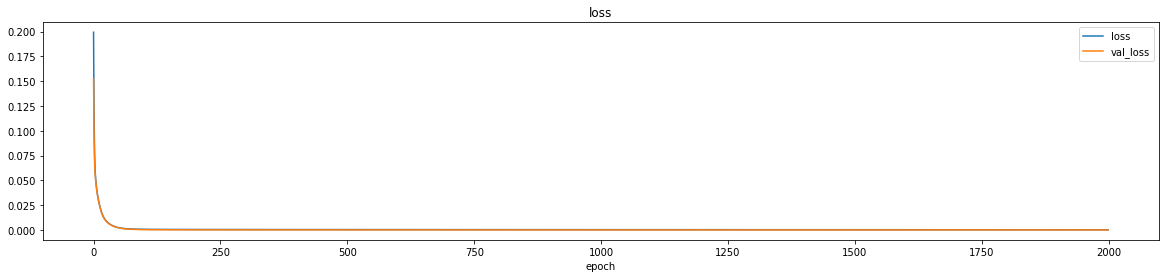

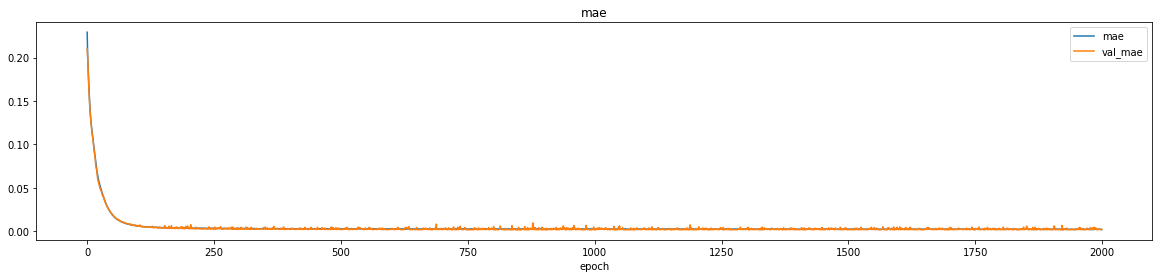

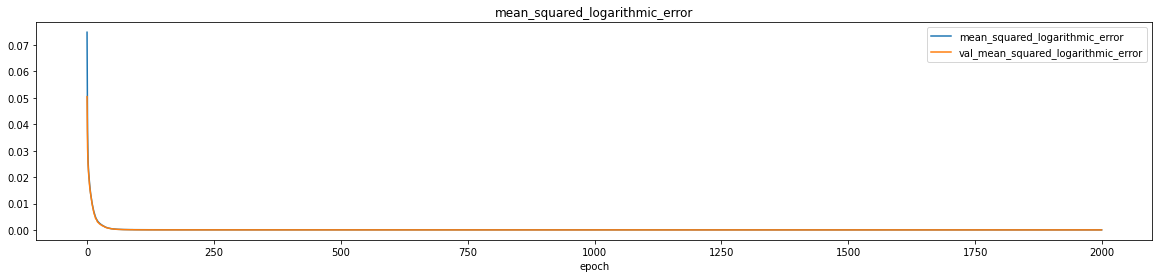

In [13]:
hist.plot(x='epoch', y=['loss', 'val_loss'], title='loss', figsize=(20,4))
hist.plot(x='epoch', y=['mae', 'val_mae'], title='mae', figsize=(20,4))
hist.plot(x='epoch', y=['mean_squared_logarithmic_error', 'val_mean_squared_logarithmic_error'], title='mean_squared_logarithmic_error', figsize=(20,4))

# Representación entrenamiento 
A partir del epoch 200 para aumentar escala vertical

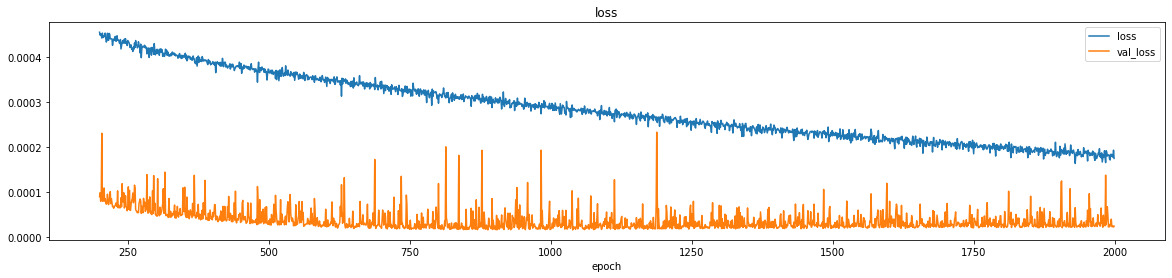

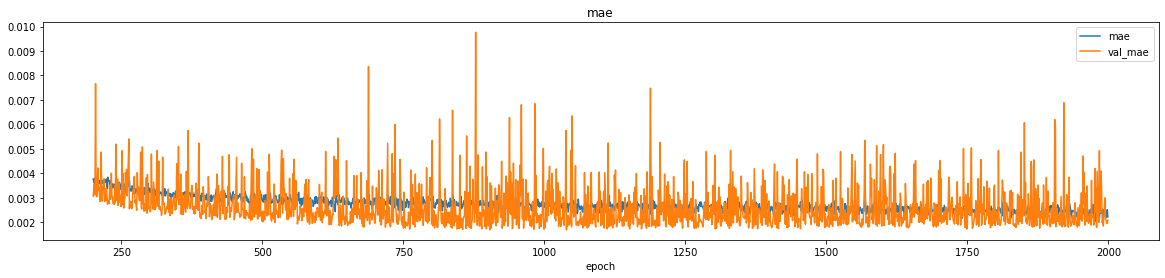

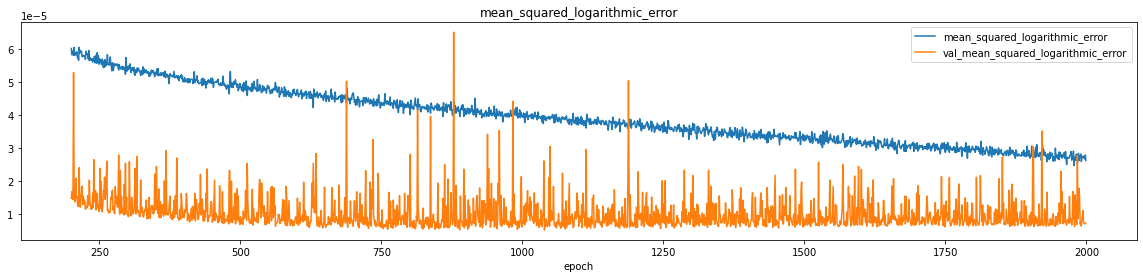

In [12]:
hist_mayor_200= hist[(hist['epoch']>=200)]
hist_mayor_200.plot(x='epoch', y=['loss', 'val_loss'], title='loss', figsize=(20,4))
hist_mayor_200.plot(x='epoch', y=['mae', 'val_mae'], title='mae', figsize=(20,4))
hist_mayor_200.plot(x='epoch', y=['mean_squared_logarithmic_error', 'val_mean_squared_logarithmic_error'], title='mean_squared_logarithmic_error', figsize=(20,4))

# Mejores épocas

In [14]:

indice_min_loss =hist['val_loss'].idxmin()
indice_min_mae =hist['val_mae'].idxmin()
indice_min_msle =hist['val_mean_squared_logarithmic_error'].idxmin()

print('Loss (MSE) mínimo: epoch {} valor {:.3E}'.format(hist['epoch'][indice_min_loss],hist['val_loss'][indice_min_loss]))
print('MAE mínimo: epoch {} valor {:.3E}'.format(hist['epoch'][indice_min_mae],hist['val_mae'][indice_min_mae]))
print('MSLE mínimo: epoch {} valor {:.3E}'.format(hist['epoch'][indice_min_msle],hist['val_mean_squared_logarithmic_error'][indice_min_msle]))


Loss (MSE) mínimo: epoch 1039 valor 1.567E-05
MAE mínimo: epoch 1039 valor 1.692E-03
MSLE mínimo: epoch 1039 valor 5.142E-06


# Cargamos el mejor modelo
Y comprobamos que la evaluación corresponde a la mejor época de la métrica de referencia MAE

In [15]:
model_best = keras.models.load_model(PATH_MODELS + OUTPUT_FILES + r'_best.h5')
model_best.evaluate(x_valid, y_valid, verbose=2)

56/56 - 0s - loss: 1.5672e-05 - mean_absolute_error: 0.0017 - mean_squared_logarithmic_error: 5.1421e-06


[1.567235085531138e-05, 0.0016920858761295676, 5.14213115820894e-06]

# Test del modelo con dataset independiente

In [17]:
data_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/output_plotdata_ccpvdz_HF_test.csv")

y_test = data_test.pop("energia")
x_test = data_test

y_test_input = y_test - minimo
x_test_input = (x_test - x_stats['mean']) / x_stats['std']

model_best.evaluate(x_test_input, y_test_input, verbose=2)

50/50 - 0s - loss: 4.7965e-04 - mean_absolute_error: 0.0020 - mean_squared_logarithmic_error: 2.3516e-04


[0.0004796453285962343, 0.001970341196283698, 0.0002351575531065464]

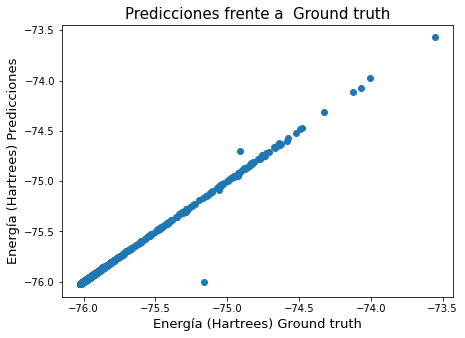

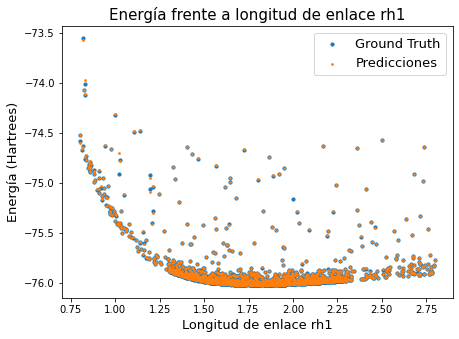

In [19]:
test_predictions = model_best.predict(x_test_input).flatten() 

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(y_test, test_predictions + minimo)
ax.set_title('Predicciones frente a  Ground truth', fontsize=15)
ax.set_xlabel('Energía (Hartrees) Ground truth', fontsize=13)
ax.set_ylabel('Energía (Hartrees) Predicciones', fontsize=13)

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x_test['rh1'], y_test, label='Ground Truth', s=10)
ax.scatter(x_test['rh1'], test_predictions + minimo, label='Predicciones', s=3)
ax.set_title('Energía frente a longitud de enlace rh1', fontsize=15)
ax.set_xlabel('Longitud de enlace rh1', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.legend(fontsize=13)
plt.show()

# Energía frente a una distancia de enlace
Fijando la otra distancia de enlace a 1.808 ua y el ángulos a 104.5 grados

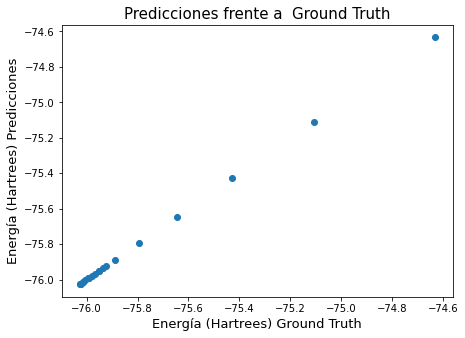

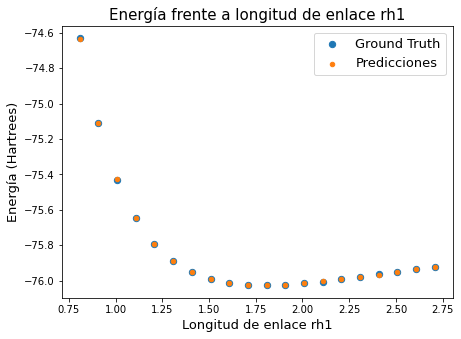

In [20]:
x_long_enlace = data[(np.round(data["ang"],1)==104.5) & (np.round(data["rh2"],3)==1.808)].copy()
y_long_enlace =x_long_enlace.pop("energia")
x_long_enlace_input = (x_long_enlace - x_stats['mean']) / x_stats['std']

test_predictions_long_enlace = model_best.predict(x_long_enlace_input).flatten()
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(y_long_enlace, test_predictions_long_enlace + minimo)
ax.set_title('Predicciones frente a  Ground Truth', fontsize=15)
ax.set_xlabel('Energía (Hartrees) Ground Truth', fontsize=13)
ax.set_ylabel('Energía (Hartrees) Predicciones', fontsize=13)


fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x_long_enlace['rh1'], y_long_enlace, label='Ground Truth', s=40)
ax.scatter(x_long_enlace['rh1'], test_predictions_long_enlace + minimo, label='Predicciones', s=20)
ax.set_title('Energía frente a longitud de enlace rh1', fontsize=15)
ax.set_xlabel('Longitud de enlace rh1', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.legend(fontsize=13)
plt.show()




plt.show()

# Energía frente al ángulo
Fijando las dos distancias de enelace a 1.808

Ángulo en el vértice de la parábola: 105.60


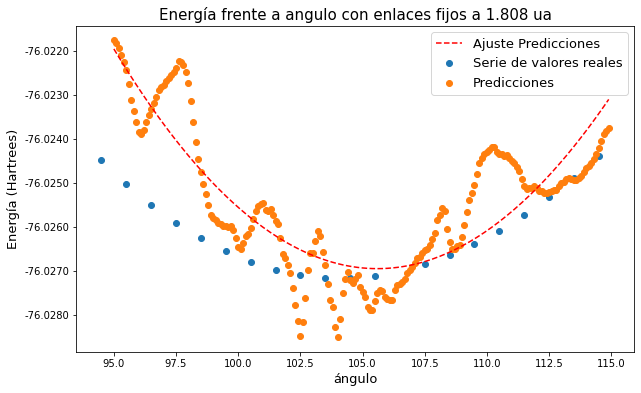

In [21]:
x_data_ang = data[(np.round(data['rh1'],3)==1.808) & (np.round(data['rh2'],3)==1.808)].copy()
y_data_ang =x_data_ang.pop("energia")

x_arange = pd.DataFrame()
x_arange['ang']= np.arange(95, 115, 0.1)
x_arange['rh1'] =1.808
x_arange['rh2'] =1.808
x_arange_input = (x_arange - x_stats['mean']) / x_stats['std']
test_predictions_arrange_ang = model_best.predict(x_arange_input).flatten()

z = np.polyfit(x_arange['ang'], test_predictions_arrange_ang + minimo, 2)
p = np.poly1d(z)
ang_vertice = -p.coefficients[1]/(2*p.coefficients[0])
print('Ángulo en el vértice de la parábola: {:.2f}'.format(ang_vertice))


fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(x_data_ang['ang'], y_data_ang , label='Serie de valores reales')
ax.scatter(x_arange['ang'], test_predictions_arrange_ang + minimo, label='Predicciones')
ax.plot(x_arange['ang'],p(x_arange['ang']),"r--", label= 'Ajuste Predicciones')
ax.set_title('Energía frente a angulo con enlaces fijos a 1.808 ua', fontsize=15)
ax.set_xlabel('ángulo', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend(fontsize=13)

plt.show()



Fijando las dos distancias de enelace a 1.708



Ángulo en el vértice de la parábola: 113.33


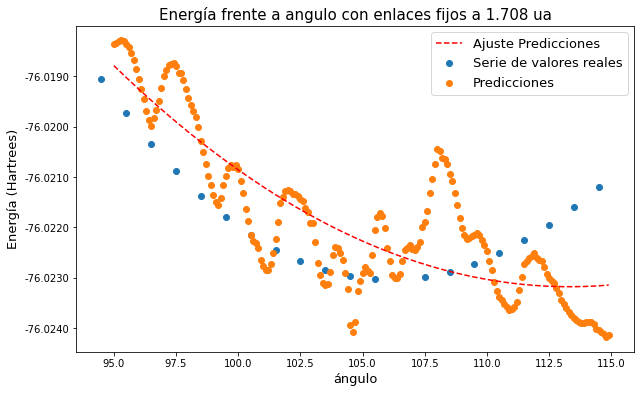

In [22]:
x_data_ang = data[(np.round(data['rh1'],3)==1.708) & (np.round(data['rh2'],3)==1.708)].copy()
y_data_ang =x_data_ang.pop("energia")

x_arange = pd.DataFrame()
x_arange['ang']= np.arange(95, 115, 0.1)
x_arange['rh1'] =1.708
x_arange['rh2'] =1.708
x_arange_input = (x_arange - x_stats['mean']) / x_stats['std']
test_predictions_arrange_ang = model_best.predict(x_arange_input).flatten()

z = np.polyfit(x_arange['ang'], test_predictions_arrange_ang + minimo, 2)
p = np.poly1d(z)
ang_vertice = -p.coefficients[1]/(2*p.coefficients[0])
print('Ángulo en el vértice de la parábola: {:.2f}'.format(ang_vertice))


fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(x_data_ang['ang'], y_data_ang , label='Serie de valores reales')
ax.scatter(x_arange['ang'], test_predictions_arrange_ang + minimo, label='Predicciones')
ax.plot(x_arange['ang'],p(x_arange['ang']),"r--", label= 'Ajuste Predicciones')
ax.set_title('Energía frente a angulo con enlaces fijos a 1.708 ua', fontsize=15)
ax.set_xlabel('ángulo', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend(fontsize=13)

plt.show()